In [1]:
import time
from copy import deepcopy

import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
import matplotlib.pylab as plt
import numpy as np
import torch
from matplotlib.ticker import FormatStrFormatter

import stg_energy.fig5_cc.energy as ue
import stg_energy.fig5_cc.helpers as helpers
import stg_energy.fig5_cc.viz as viz
from stg_energy.fig3_active_subspaces.viz import energy_scape
from pyloric import create_prior
from pyloric import simulate
from stg_energy.common import col, get_labels_8pt
from stg_energy.fig5_cc.conditional_density import (
    buildCondCovMatrix,
    conditional_correlation,
    conditional_mutual_information,
    eval_conditional_density,
    partialCorrelation,
)
from sklearn.linear_model import LinearRegression
from sbi.analysis import ActiveSubspace
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin
from pyloric import create_prior

# Figure 5

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
PANEL_B0 = "../svg/panel_b0.svg"
PANEL_C0 = "../svg/panel_c0.svg"
PANEL_C1 = "../svg/panel_c1.svg"
PANEL_C_CBAR = "../svg/panel_c_cbar.svg"
PANEL_C2 = "../svg/panel_c2.svg"
PANEL_C3 = "../svg/panel_c3.svg"
PANEL_D1 = "../svg/panel_d1.svg"
PANEL_D2 = "../svg/panel_d2.svg"
PANEL_D3 = "../svg/panel_d3.svg"
PANEL_D4 = "../svg/panel_d4.svg"
PANEL_D5 = "../svg/panel_d5.svg"
PANEL_D6 = "../svg/panel_d6.svg"

PANEL_D1_supp = "../svg/panel_d1_supp.svg"
PANEL_D2_supp = "../svg/panel_d2_supp.svg"
PANEL_D3_supp = "../svg/panel_d3_supp.svg"
PANEL_D4_supp = "../svg/panel_d4_supp.svg"
PANEL_D5_supp = "../svg/panel_d5_supp.svg"
PANEL_D6_supp = "../svg/panel_d6_supp.svg"


PANEL_suppA_traces = "../svg/panel_suppA_traces.svg"
PANEL_suppB_traces = "../svg/panel_suppB_traces.svg"
PANEL_suppC_traces = "../svg/panel_suppC_traces.svg"

PANEL_REG_supp_fraction_ABPD = "../svg/panel_REG_supp_fraction_ABPD.svg"
PANEL_REG_supp_fraction_LP = "../svg/panel_REG_supp_fraction_LP.svg"
PANEL_REG_supp_fraction_PY = "../svg/panel_REG_supp_fraction_PY.svg"
PANEL_REG_supp_fraction_syn = "../svg/panel_REG_supp_fraction_syn.svg"

In [4]:
import pandas as pd

In [5]:
path_sims_after_classifier = "../../../results/simulation_data_Tube_MLslurm_cluster/simulate_11deg_R3_predictives_at_11deg/data/"

params = pd.read_pickle(path_sims_after_classifier + "valid_circuit_parameters.pkl").to_numpy()
stats = pd.read_pickle(path_sims_after_classifier + "valid_simulation_outputs.pkl").to_numpy()
seeds = np.load(path_sims_after_classifier + "valid_seeds.npy")
# data = np.load(datafile)
# params = data["params"]
# stats = data["stats"]
# seeds = data["seeds"]

stats_mean = np.mean(stats, axis=0)
stats_std = np.std(stats, axis=0)

In [6]:
import sys
sys.path.append("home/michael/Documents/sbi/sbi/utils/user_input_checks_utils")
import sys
from sbi.utils import user_input_checks_utils

sys.modules["sbi.user_input.user_input_checks_utils"] = user_input_checks_utils
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)
    posterior._device = 'cpu'

/home/michael/Documents/STG_energy_sbi/sbi/inference/posteriors/base_posterior.py:1089: UserWarning: You had saved the posterior under an older version of `sbi`. To make the loaded version comply with the version you are using right now, we had to set the following attributes: `self._device = cpu` `self._num_iid_trials = None` `self._iid_methods = ['snle', 'snre_a', 'snre_b']` `self._allow_iid_x = False` `self._sample_with = rejection`
  warn(warning_description + warning_msg)


In [7]:
prior = create_prior(as_torch_dist=True)
dimensions = 31
params_mean = prior.mean.numpy()
params_std = prior.stddev.numpy()

summstats_experimental_11 = np.load("../../../results/experimental_data/xo_11deg.npy")

In [8]:
posterior.set_default_x(torch.as_tensor([summstats_experimental_11], dtype=torch.float32))

In [9]:
lims_unnorm = np.asarray(
    [prior.support.base_constraint.lower_bound.numpy(), prior.support.base_constraint.upper_bound.numpy()]
).T
lims_unnorm[:, 0] += 1e-8
lims_unnorm[:, 1] -= 1e-8

In [10]:
lims = np.reshape([-np.sqrt(3), np.sqrt(3)] * 46, (46, 2))

### Find a value to condition on

In [11]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
sample_seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

sample_params = theta.to_numpy()
sample_stats = x.to_numpy()

In [12]:
from decimal import Decimal

all_labels = []
for dim_i in range(31):
    if dim_i > len(params_mean) - 7.5:  # synapses
        if dim_i == 24:
            all_labels.append(
                [r"$\mathdefault{0.01}$   ", r"$\mathdefault{10000}\;\;\;\;$   "]
            )
        else:
            all_labels.append(
                [r"$\;\;\mathdefault{0.01}$", r"$\mathdefault{1000}\;\;\;\;$ "]
            )
    else:  # membrane conductances
        num_after_digits = -int(
            np.log10(lims[dim_i, 1] * params_std[dim_i] + params_mean[dim_i])
        )
        if num_after_digits > 2:
            num_after_digits = 2
        labels = [round(lims_unnorm[dim_i, num_tmp]) for num_tmp in range(2)]
                
        new_labels = []
        counter = 0
        for l in labels:
            if counter == 0:
                new_labels.append(r"$\mathdefault{" + str(l) + "}$")
            else:
                new_labels.append(r"$\mathdefault{" + str(l) + "}\;\;\;$ ")
            counter += 1
        all_labels.append(new_labels)

# Panel A: perturbing one parameter breaks activity

Good setups:  
sample_number=2, bad_condition[0]=0.11, dims=0,5  
sample_number=8, bad_condition[0]=0.11, dims=0,5  

In [13]:
sample_number = 0
condition1 = deepcopy(sample_params[sample_number])  # 5,6 is good
condition_stats = deepcopy(sample_stats[sample_number])
condition1_norm = torch.as_tensor([condition1])

### Perturb parameter set

In [14]:
condition1[0] = 270.0
condition1[5] = 85
bad_condition = deepcopy(condition1)
bad_condition[0] = 450.0   # 0.28
condition1_norm = torch.as_tensor(condition1).unsqueeze(0)

In [15]:
# all_dists = []
# resolution = 100

# for ppp in range(31):
#     counts, _, _ = plt.hist(sample_params[:, ppp], range=lims_unnorm[ppp], bins=100)
#     inds = np.where(counts>0.0)
#     max_min_dist = np.max(inds) - np.min(inds)+1
#     all_dists.append(max_min_dist)
# all_dists = np.asarray(all_dists)
# all_baseline_fracs = all_dists / resolution

In [16]:
# my_samples = posterior.sample((10000,))
# probs = posterior.log_prob(my_samples).detach().numpy()
# sorted_log_probs = np.sort(probs)
# threshold_for_simulating = sorted_log_probs[1000]
# threshold_for_simulating = np.exp(threshold_for_simulating) / 1e10 # subtract for numerical stability
# print("threshold_for_simulating", threshold_for_simulating)

In [17]:
# all_dists = []
# for ppp in range(31):

#     p_vector = np.exp(eval_conditional_density(
#         posterior,
#         torch.as_tensor(condition1_norm, dtype=torch.float32),
#         lims_unnorm,
#         ppp,
#         ppp,
#         resolution=resolution,
#         log=True
#     ) - 100 )

#     threshold =  deepcopy(threshold_for_simulating)

#     inds = np.where(p_vector>threshold)
#     if np.any(p_vector>threshold): 
#         max_min_dist = np.max(inds) - np.min(inds)+1
#     else:
#         max_min_dist = 0.0
#     all_dists.append(max_min_dist)
# all_dists = np.asarray(all_dists)
# all_fracs = all_dists / resolution
# all_relative_fracs = all_fracs / all_baseline_fracs

In [18]:
# from stg_energy.fig3_active_subspaces.viz import py_sensitivity_bars, synapse_sensitivity_bars

In [19]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     py_sensitivity_bars(all_relative_fracs[0:8][None,], ylim=[0.0, 1.0], figsize=(1.9, 1.0), ylabel='Fraction of \n '+r'marginal $\theta$ range', plot_labels=True, color="#3182bd")
# #     plt.savefig(PANEL_REG_supp_fraction_ABPD, facecolor='None', transparent=False)

In [20]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     py_sensitivity_bars(all_relative_fracs[8:16][None,], ylim=[0.0, 1.0], figsize=(1.9, 1.0), ylabel='', plot_labels=False, color="#fc8d59")
# #     plt.savefig(PANEL_REG_supp_fraction_LP, facecolor='None', transparent=False)

In [21]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     py_sensitivity_bars(all_relative_fracs[16:24][None,], ylim=[0.0, 1.0], figsize=(1.9, 1.0), ylabel='', plot_labels=False, color="#2ca25f")
# #     plt.savefig(PANEL_REG_supp_fraction_PY, facecolor='None', transparent=False)

In [22]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     synapse_sensitivity_bars(torch.as_tensor(all_relative_fracs[24:][None,]), ylim=[0.0, 1.0], figsize=(1.6, 1.0), ylabel='', color="k")
# #     plt.savefig(PANEL_REG_supp_fraction_syn, facecolor='None', transparent=False)

In [23]:
# my_samples = posterior.sample((10000,))
probs = posterior.log_prob(sample_params).detach().numpy()
sorted_log_probs = np.sort(probs)
threshold_for_simulating = sorted_log_probs[int(0.1*sample_params.shape[0])]
print("threshold_for_simulating", threshold_for_simulating)
threshold_for_simulating = np.exp(threshold_for_simulating) # subtract for numerical stability
print("threshold_for_simulating", threshold_for_simulating)

threshold_for_simulating -42.22698
threshold_for_simulating 4.582013e-19


/home/michael/Documents/STG_energy/stg_energy/fig5_cc/viz.py:388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


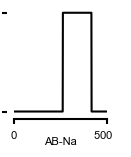

In [24]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname="../../../.matplotlibrc"):

    labels_ = get_labels_8pt()
    labels_[9] += ""

    fig, axes = viz.singleOneDmarginal(
        pdfs=[posterior],
        samples=sample_params,
        # subset=[0,1,2,3,4,5,6,7], # ,25,26,28
        subset=[0],  # ,25,26,28
        limits=lims_unnorm,
        ticks=lims_unnorm,
        tick_labels=all_labels,
        fig_size=(1.2, 1.3),
        labels=labels_,
#         points=[condition1, bad_condition],
        scatter_offdiag={"rasterized": True, "alpha": 1.0},
        # points_offdiag={'marker':'o', 'markeredgecolor':'w', 'markersize':3.6, 'markeredgewidth':0.5, 'path_effects':[pe.Stroke(linewidth=1.2, foreground='k'), pe.Normal()]},
        points_colors=[col["CONSISTENT1"], col["INCONSISTENT"]],
        samples_colors=["k"],
        condition=torch.as_tensor(condition1_norm, dtype=torch.float32),
        diag=["cond"],
        upper=["cond"],
        hist_offdiag={"bins": 500},
        hist_diag={"bins": 500},
        log=True,
        thr_at=np.log(threshold_for_simulating)
    )
    plt.savefig(PANEL_B0, facecolor='None', transparent=True)
    plt.show()

In [25]:
theta_np = theta.to_numpy()
num_test = 500
energies = np.sum(x['energies'].to_numpy(), axis=1) / 10 / 1000

test_params = theta_np[:num_test]
train_params = theta_np[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

train_energy_ABPD = torch.as_tensor(energies)[num_test:].unsqueeze(1)
test_energy_ABPD = torch.as_tensor(energies)[:num_test].unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

regressor = LinearRegression()
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)
predictions = fitted_reg.predict(test_params_norm)
coeff = np.asarray([fitted_reg.coef_[0]])
coeff = coeff / np.linalg.norm(coeff)

In [26]:
index_of_param = 0
lims_na = lims_unnorm[index_of_param]
eval_vals = np.linspace(lims_na[0], lims_na[1], 200)
hundred_cond = condition1_norm.repeat((200, 1))
hundred_cond[:, index_of_param] = torch.as_tensor(eval_vals)
posterior_probs = posterior.log_prob(hundred_cond)
eval_vals_norm = (hundred_cond - mean_params) / std_params

predicted_energy_norm = fitted_reg.predict(eval_vals_norm.numpy())
predicted_energy = predicted_energy_norm * std_energy.numpy() + mean_energy.numpy()
predicted_energy = predicted_energy[posterior_probs > np.log(threshold_for_simulating)]
accepted = eval_vals[posterior_probs > np.log(threshold_for_simulating)]

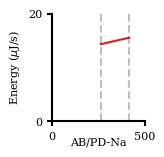

In [46]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.2, 1.4))
    ax.plot([accepted[0], accepted[0]], [0.0, 20.0], c="gray", alpha=0.5, linestyle="--")
    ax.plot([accepted[-1], accepted[-1]], [0.0, 20.0], c="gray", alpha=0.5, linestyle="--")
    ax.plot(accepted, predicted_energy, c="#e31a1c")
    ax.set_ylim([0, 20])
    ax.set_ylabel(r"Energy ($\mu$J/s)")
    ax.set_xlabel("AB/PD-Na", labelpad=-3)
    ax.set_xticks([0, 500])
    ax.set_xlim([0, 500])
    ax.set_yticks([0, 20])
    plt.savefig(PANEL_B0, facecolor='None', transparent=True)
    plt.savefig("panel_revision.png")

### Compute the energy to be saved from moving in 1D

In [29]:
p = create_prior()

In [30]:
condition_pd = pd.DataFrame([condition1], columns=p.sample((1,)).columns)

In [31]:
out_target = simulate(deepcopy(condition_pd.loc[0]), seed=0)

In [32]:
time_vec = np.arange(0, 11000, 0.025)

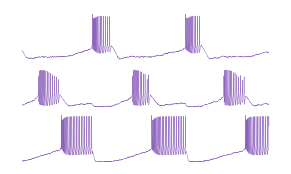

In [33]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(3.5, 2.0))
    fig = viz.vis_sample_plain(
        out_target,
        time_vec,
        ax,
        time_len=120000,
        offset=40000,
        col=col["CONSISTENT1"],
        scale_bar=False,
    )
    plt.savefig(PANEL_suppA_traces, facecolor='None', transparent=True)
    plt.show()

In [34]:
condition_pd_bad = pd.DataFrame([bad_condition], columns=p.sample((1,)).columns)
out_target = simulate(deepcopy(condition_pd_bad.loc[0]), seed=4) # 6

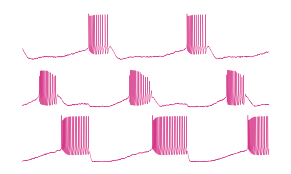

In [35]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(3.5, 2.0))
    fig = viz.vis_sample_plain(
        out_target,
        time_vec,
        ax,
        time_len=120000,
        col=col["INCONSISTENT"],
        offset=300000,
        scale_bar=False,
    )
    plt.savefig(PANEL_suppB_traces, facecolor='None', transparent=True)
    plt.show()

# Panel B: cure the parameter set

In [36]:
cured_condition = deepcopy(bad_condition)
cured_condition[5] = 95.0 # 0.087

In [37]:
def revert_positions(a):
    """
    Because we swap the dimensions of the two parameters (such that LP-CaS is on the x-axis), we also have to flip these values for the points.
    """
    a_new = deepcopy(a)
    a_new[5] = deepcopy(a[0])
    a_new[0] = deepcopy(a[5])
    return a_new

In [38]:
# from decimal import Decimal

# all_labels = []
# for dim_i in range(31):
#     if dim_i > len(params_mean) - 7.5:  # synapses
#         if dim_i == 24:
#             all_labels.append(
#                 [r"$\mathdefault{0.01}$   ", r"$\mathdefault{10000}$   "]
#             )
#         else:
#             all_labels.append(
#                 [r"$\;\;\mathdefault{0.01}$", r"$\mathdefault{1000}$ "]
#             )
#     else:  # membrane conductances
#         num_after_digits = -int(
#             np.log10(lims[dim_i, 1] * params_std[dim_i] + params_mean[dim_i])
#         )
#         if num_after_digits > 2:
#             num_after_digits = 2
#         labels = [
#             round(
#                 Decimal(
#                     (lims[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i])
#                     / 0.628e-3
#                 ),
#                 num_after_digits,
#             )
#             for num_tmp in range(2)
#         ]
#         new_labels = []
#         counter = 0
#         for l in labels:
#             if counter == 0:
#                 new_labels.append(r"$\mathdefault{" + str(int(l)) + "}$")
#             else:
#                 new_labels.append(r"$\mathdefault{" + str(int(l)) + "}$")
#             counter += 1
#         all_labels.append(new_labels)

In [39]:
all_labels[5][1] = "$\\mathdefault{150}$"
all_labels[0][1] = "$\\mathdefault{500}$"

/home/michael/Documents/STG_energy/stg_energy/fig5_cc/viz.py:698: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


running this upper


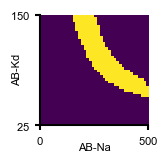

In [40]:
# condition1_swap = revert_positions(condition1)
# bad_condition_swap = revert_positions(bad_condition)
# cured_condition_swap = revert_positions(cured_condition)

with mpl.rc_context(fname="../../../.matplotlibrc"):

    labels_ = get_labels_8pt()
    labels_[9] += ""

    _ = viz.single2Dmarginal(
        pdfs=[posterior],
        samples=sample_params,
        subset=[5, 0],  # 0,1   0,4    0,5
        #subset=[0,5],  # 0,1   0,4    0,5
        limits=lims_unnorm,
        ticks=lims_unnorm,
        tick_labels=all_labels,
        fig_size=(1.4, 1.4),
        labels=labels_,
#         points=[condition1, bad_condition, cured_condition],
        scatter_offdiag={"rasterized": True, "alpha": 1.0},
        points_offdiag={'markersize':12.6},
        points_colors=[col["CONSISTENT1"], col["INCONSISTENT"], col["GT"]],
        samples_colors=[col["SNPE"]],
        condition=torch.as_tensor(condition1_norm, dtype=torch.float32),
        diag=None,
        upper=["cond"],
        hist_offdiag={"bins": 40},
        log=True,
        thr_at=np.log(threshold_for_simulating)
    )

    plt.savefig(PANEL_C0, facecolor='None', transparent=True)
    plt.show()

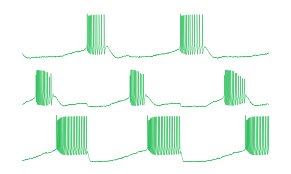

In [41]:
condition_pd_cured = pd.DataFrame([cured_condition], columns=p.sample((1,)).columns)
out_target = simulate(deepcopy(condition_pd_cured.loc[0]), seed=0)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(3.5, 2.0))
    fig = viz.vis_sample_plain(
        out_target, time_vec, ax, time_len=120000, col=col["GT"], offset=45000, scale_bar=False
    )
    plt.savefig(PANEL_suppC_traces, facecolor='None', transparent=True)
    plt.show()

# Panel C: show that energy is not constant in this plane

In [42]:
# pairs = np.asarray(
#     [[0, 2], [4, 5], [10, 11], [11, 12], [17, 18], [18, 19], [22, 26], [24, 25]]
# )  # [18,19]
pairs = np.asarray(
    [[0, 5]]
)  # [18,19]
neuron_to_observe = ["PM", "PM", "LP", "LP", "PY", "PY", "PM", "PM"]

In [43]:
condition1_norm = torch.as_tensor([condition1], dtype=torch.float32)

In [44]:
condition1 = deepcopy(sample_params[sample_number])  # 5,6 is good
condition1_stats = deepcopy(sample_stats[sample_number])
condition1_norm = torch.as_tensor([condition1])

In [45]:
grid_bins = 50
patience = 3

In [46]:
xo =summstats_experimental_11

In [47]:
# energies = x["energies"]
# energies_tt = torch.as_tensor(energies.to_numpy())
# x_tt = torch.as_tensor(x.to_numpy(), dtype=torch.float32)

# num_test = 1000
# theta_test = torch.as_tensor(theta.to_numpy()[:num_test], dtype=torch.float32)
# theta_train = torch.as_tensor(theta.to_numpy()[num_test:], dtype=torch.float32)

# train_energy = torch.as_tensor(
#     energies_tt[num_test:, 0].unsqueeze(1), dtype=torch.float32
# )
# test_energy = torch.as_tensor(
#     energies_tt[:num_test, 0].unsqueeze(1), dtype=torch.float32
# )
# torch.manual_seed(0)
# sensitivity = ActiveSubspace(posterior)
# converged_nn_AB = sensitivity.add_property(
#     theta_train, train_energy, hidden_features=20, num_blocks=1
# ).train()

In [48]:
# with open(
#     "../../../results/conditional_correlation_energy/converged_net_AB.pickle",
#     "wb",
# ) as handle:
#     pickle.dump(converged_nn_AB, handle)

In [49]:
# with open(
#     "../../../results/conditional_correlation_energy/converged_net_AB.pickle",
#     "rb",
# ) as handle:
#     converged_nn_AB = pickle.load(handle)

In [50]:
vec = np.linspace(-np.sqrt(3), np.sqrt(3), grid_bins)
all_energy_images = []
all_conditional_correlations = []

for counter, pair in enumerate(pairs):
    print("New pair")
    dim1 = pair[0]
    dim2 = pair[1]

    p_vector = eval_conditional_density(
        posterior, condition1_norm, lims_unnorm, dim1, dim2, resolution=50, log=False
    )
    p_vector = p_vector / np.max(p_vector)  # just to scale it to 1

    # correct the limits a bit: when we evaluate exactly at the bounds, it gets 0.0.
    lims_unnorm[:, 0] += 1e-12
    lims_unnorm[:, 1] -= 1e-12

    # get the energies in the conditional plane
    energy_image, energy_image_specific_neuron, _, _ = ue.energy_of_conditional(
        posterior,
        torch.as_tensor([condition1], dtype=torch.float32),
        grid_bins,
        threshold_for_simulating,
        dim1,
        dim2,
        lims_unnorm,
        stats_std=stats_std,
        neuron_to_observe=neuron_to_observe[counter],
        patience=patience,
        regression_net=fitted_reg,
        theta_mean=mean_params,
        theta_std=std_params,
        x_mean=mean_energy.numpy(),
        x_std=std_energy.numpy(),
    )

    all_conditional_correlations.append(p_vector)
    all_energy_images.append(energy_image)

#     np.save(f'../../results/conditional_correlation_energy/200930_sample{sample_number}_dims{dim1}_{dim2}_grid{grid_bins}_patience{patience}_p_vector_nn', p_vector)
#     np.save(f'../../results/conditional_correlation_energy/200930_sample{sample_number}_dims{dim1}_{dim2}_grid{grid_bins}_patience{patience}_energy_nn', energy_image)
#     np.save(f'../../results/conditional_correlation_energy/200930_sample{sample_number}_dims{dim1}_{dim2}_grid{grid_bins}_patience{patience}_energy_specific_neuron_nn', energy_image_specific_neuron)

New pair


In [51]:
# all_conditional_correlations = np.load(
#     "../../results/conditional_correlation_energy/200930_dim10_dim25_grid50_patience3_p_vector.npy"
# )
# all_energy_images = np.load(
#     "../../results/conditional_correlation_energy/200930_dim10_dim25_grid50_patience3.npy"
# )

In [52]:
# all_conditional_correlations = np.asarray(all_conditional_correlations)
# energy_image = np.asarray(all_energy_images)

In [53]:
energy_image = energy_image_specific_neuron

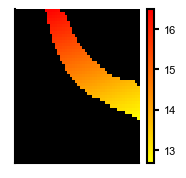

In [54]:
# build colormap
colors = plt.cm.autumn(np.linspace(0, 1, 2048))
blacks = np.ones_like(colors)
blacks[:, :3] = 0.0

# combine them and build a new colormap
colors = np.vstack((blacks[-1], np.flipud(colors)))
mymap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)

image = deepcopy(energy_image) #  / 40000
# image[image == 0.0] = np.max(image) + 1.0
max_val_of_image = np.max(image[image != np.max(image)])
min_val_of_image = np.min(image[image != np.min(image)])
diff = max_val_of_image - min_val_of_image
val_for_black_parts = min_val_of_image - 1/200*diff
image[image == np.min(image)] = val_for_black_parts
val_for_white_parts = max_val_of_image + 1/200*diff
image[image == np.max(image)] = val_for_white_parts

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    h = ax.imshow(image, origin="lower", aspect="auto", cmap=mymap)
    plt.colorbar(h)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    plt.show()

In [55]:
neurons = ["AB/PD1", "AB/PD2", "LP1", "LP2", "PY1", "PY2", "syn1", "syn2"]

seeds_max = [0, 0, 0, 1, 0, 0, 0, 0]
seeds_min = [0, 0, 1, 1, 0, 0, 0, 0]

t_max_mins = [125000, 125000, 100000, 100000, 112000, 113000, 110000, 125000]
t_max_maxs = [145000, 145000, 120000, 120000, 132000, 133000, 130000, 145000]

t_min_mins = [120000, 125000, 100000, 100000, 112000, 113000, 110000, 125000]
t_min_maxs = [140000, 145000, 120000, 120000, 132000, 133000, 130000, 145000]

neuron_to_plot = [0, 0, 1, 1, 2, 2, 2, 0]

set_to_inspect = 0

# find dims
# energy_image = all_energy_images[set_to_inspect]
pair = pairs[set_to_inspect]
dim1 = pair[0]
dim2 = pair[1]

vec1 = np.linspace(lims_unnorm[dim1, 0], lims_unnorm[dim1, 1], grid_bins)
vec2 = np.linspace(lims_unnorm[dim2, 0], lims_unnorm[dim2, 1], grid_bins)

In [56]:
np_pair = np.asarray(pair)
labels = get_labels_8pt()
labels_for_x_and_y = labels[np_pair]

-------- High energy set --------
max_energy_pixel (49, 12)


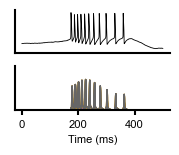

In [57]:
###################################################################################################
#                                        maximum energy set                                       #
###################################################################################################

print("-------- High energy set --------")
cond1_norm_tmp = deepcopy(condition1_norm[0])
tmp_energy_image = deepcopy(energy_image)
# find parameter value that had maximum energy
max_energy_pixel = np.unravel_index(tmp_energy_image.argmax(), tmp_energy_image.shape)
print("max_energy_pixel", max_energy_pixel)
# replace the parameter values
param1 = vec1[max_energy_pixel[0]]
param2 = vec2[max_energy_pixel[1]]

cond1_norm_tmp[dim1] = param1
cond1_norm_tmp[dim2] = param2

# simulate and build energy scape
parameter_set = cond1_norm_tmp
set_pd = pd.DataFrame([parameter_set], columns=p.sample((1,)).columns)

out_target = simulate(deepcopy(set_pd).loc[0], seed=8607175, track_currents=True, track_energy=True)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    energy_scape(
        out_target,
        time_vec,
        figsize=(2.0, 1.3),
        cols=['k', 'k', 'k'],
        time_len=20000,
        offset=153000,
        neuron=neuron_to_plot[set_to_inspect],
        ylabels=False,
    )
    plt.savefig(PANEL_C2, facecolor='None', transparent=True)
    plt.show()

In [58]:
max_energy_pixel

(49, 12)

-------- Low energy set --------
min_energy_pixel (14, 49)


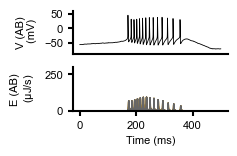

In [59]:
###################################################################################################
#                                        minimum energy set                                       #
###################################################################################################
print("-------- Low energy set --------")
tmp_energy_image = deepcopy(energy_image)
tmp_energy_image[tmp_energy_image <=0.0] = 1e10
min_energy_pixel = np.unravel_index(tmp_energy_image.argmin(), tmp_energy_image.shape)
print("min_energy_pixel", min_energy_pixel)
param1 = vec1[min_energy_pixel[0]]
param2 = vec2[min_energy_pixel[1]]

cond1_norm_tmp[dim1] = param1
cond1_norm_tmp[dim2] = param2

parameter_set = cond1_norm_tmp
set_pd = pd.DataFrame([parameter_set], columns=p.sample((1,)).columns)

out_target = simulate(deepcopy(set_pd).loc[0], seed=8607175, track_currents=True, track_energy=True)
with mpl.rc_context(fname="../../../.matplotlibrc"):
    energy_scape(
        out_target,
        time_vec,
        figsize=(2.0, 1.3),
        cols=['k', 'k', 'k'],
        time_len=20000,
        offset=300300,
        neuron=neuron_to_plot[set_to_inspect],
        ylabels=True,
    )
    plt.savefig(PANEL_C3, facecolor='None', transparent=True)
    plt.show()

# Plot the figure again, but with the points of max and min

In [60]:
prior = create_prior(as_torch_dist=True)

In [61]:
lower0 = prior.support.base_constraint.lower_bound[pairs[set_to_inspect][0]].item()
upper0 = prior.support.base_constraint.upper_bound[pairs[set_to_inspect][0]].item()
lower1= prior.support.base_constraint.lower_bound[pairs[set_to_inspect][1]].item()
upper1 = prior.support.base_constraint.upper_bound[pairs[set_to_inspect][1]].item()

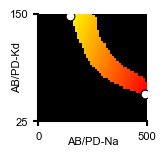

In [62]:
# build colormap
colors = plt.cm.autumn(np.linspace(0, 1, 2048))
blacks = np.ones_like(colors)
blacks[:, :3] = 0.0

# combine them and build a new colormap
colors = np.vstack((blacks[-1], np.flipud(colors)))
mymap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)

image = deepcopy(energy_image) #/ 40000
max_val_of_image = np.max(image)
min_val_of_image = np.min(image[image != np.min(image)])
diff = max_val_of_image - min_val_of_image
val_for_black_parts = min_val_of_image - 1/200*diff
image[image == np.min(image)] = val_for_black_parts

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 1.4))
    h = ax.imshow(image.T, origin="lower", aspect="auto", cmap=mymap)
    ax.scatter(min_energy_pixel[0], min_energy_pixel[1]-0.5, s=40, color='#FFFFFF', edgecolors='k', linewidths=0.8)
    # -0.5 because otherwise the dot is cut off.
    ax.scatter(max_energy_pixel[0]-0.5, max_energy_pixel[1], s=40, color='#FFFFFF', edgecolors='k', linewidths=0.8)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
#     ax.spines['top'].set_visible(True)
#     ax.spines['right'].set_visible(True)
    ax.set_xlabel(labels_for_x_and_y[0], labelpad=-3)
    ax.set_xlabel("AB/PD-Na", labelpad=-3)
    ax.set_ylabel(labels_for_x_and_y[1], labelpad=-9)
    ax.set_ylabel("AB/PD-Kd", labelpad=-9)
    ax.set_xticks([-0.5, image.shape[0]-0.5])
    ax.set_yticks([-0.5, image.shape[1]-0.5])
    ax.set_xticklabels([int(np.round(lower0)), int(np.round(upper0))])
    ax.set_yticklabels([int(np.round(lower1)), int(np.round(upper1))])
    
#     ax.annotate(
#         "",
#         xy=(45, 12),
#         xytext=(37, 7),
#         arrowprops=dict(
#             facecolor="w",
#             edgecolor="w",
#             headwidth=4.4,
#             headlength=4.7,
#             width=0.1,
#         ),
#     )
    
#     ax.annotate(
#         "",
#         xy=(16, 45),
#         xytext=(10, 36),
#         arrowprops=dict(
#             facecolor="w",
#             edgecolor="w",
#             headwidth=4.4,
#             headlength=4.7,
#             width=0.1,
#         ),
#     )
    
    plt.savefig(PANEL_C1, facecolor='None', transparent=True)
    plt.show()

<ipython-input-63-5374c41b9f7a>:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(h)


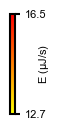

In [63]:
with mpl.rc_context(fname="../../../.matplotlibrc"):

    # draw a new figure and replot the colorbar there
    fig, ax = plt.subplots(figsize=(1.3, 1.3))
    cbar = plt.colorbar(h)
    cbar.set_ticks([val_for_black_parts, max_val_of_image])
    cbar.set_ticklabels(['%.1f' %val_for_black_parts, '%.1f' %max_val_of_image])
    cbar.set_label("E ($\mu$J/s)", labelpad=-7)

    ax.remove()
    plt.savefig(PANEL_C_CBAR, facecolor='None', transparent=True)
    plt.show()

# Panel D: summarize the energy gains in matrizes

### AB/PD

### Select a bunch of conditions that have high posterior probability

In [64]:
probs_of_sample_params = posterior.log_prob(sample_params).numpy()

In [65]:
arbitrary_thr_to_increase_requirement = 5.0
sample_params_above_thr = sample_params[probs_of_sample_params > np.log(threshold_for_simulating) + arbitrary_thr_to_increase_requirement]
print("num that fulfilled the criterion", sample_params_above_thr.shape)

num that fulfilled the criterion (2128, 31)


In [66]:
condition_batch = torch.as_tensor(deepcopy(sample_params_above_thr[:10]))

In [67]:
condition1_original = deepcopy(sample_params[sample_number])  # 5,6 is good
condition1_stats_original = deepcopy(sample_stats[sample_number])
condition1_norm_original = torch.as_tensor([condition1_original])

In [68]:
condition1_norm_original.shape

torch.Size([1, 31])

In [70]:
# everything_ABPD = []
# for specific_condition in condition_batch:
#     (
#         all_conditional_correlations,
#         all_energy_images,
#         all_energy_specific,
#         all_energy_per_spike,
#         all_num_spikes_per_burst,
#     ) = helpers.generate_and_store_data(
#         neuron1=np.arange(8),
#         neuron2=np.arange(8),
#         neuron_to_observe='PM',
#         grid_bins=grid_bins,
#         posterior=posterior,
#         condition1_norm=specific_condition.unsqueeze(0),
#         lims_unnorm=lims_unnorm,
#         stats_std=stats_std,
#         regression_net=fitted_reg,
#         theta_mean=mean_params,
#         theta_std=std_params,
#         x_mean=mean_energy.numpy(),
#         x_std=std_energy.numpy(),
#         min_prob=threshold_for_simulating,
#     )
#     print("Done")
#     everything_ABPD.append(all_energy_specific)

In [71]:
# with open("../../../results/conditional_correlation_energy/211021_everything_abpd.pickle", "wb") as handle:
#     pickle.dump(everything_ABPD, handle)

In [72]:
with open("../../../results/conditional_correlation_energy/211021_everything_abpd.pickle", "rb") as handle:
    everything_ABPD = pickle.load(handle)

In [73]:
# with open(
#     "../../../results/conditional_correlation_energy/211007_PM_all_stored_data_from_all_energy_specific_nn.pickle",
#     "rb",
# ) as handle:
#     all_energy_images_specific = pickle.load(handle)

max diag 11.677301018358078
max 30.042526732375507


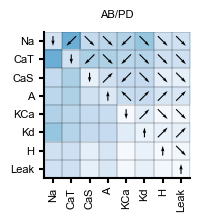

In [74]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.energy_gain_matrix(everything_ABPD, figsize=(1.9, 1.9), title="AB/PD", lims=[0,60])
    plt.savefig(PANEL_D1, facecolor='None', transparent=True)
    plt.show()

### LP

In [75]:
# energies = x["energies"]
# energies_tt = torch.as_tensor(energies.to_numpy())
# x_tt = torch.as_tensor(x.to_numpy(), dtype=torch.float32)

# num_test = 1000
# theta_test = torch.as_tensor(theta.to_numpy()[:num_test], dtype=torch.float32)
# theta_train = torch.as_tensor(theta.to_numpy()[num_test:], dtype=torch.float32)

# train_energy = torch.as_tensor(
#     energies_tt[num_test:, 1].unsqueeze(1), dtype=torch.float32
# )
# test_energy = torch.as_tensor(
#     energies_tt[:num_test, 1].unsqueeze(1), dtype=torch.float32
# )
# torch.manual_seed(0)
# sensitivity = ActiveSubspace(posterior)
# converged_nn_LP = sensitivity.add_property(
#     theta_train, train_energy, hidden_features=20, num_blocks=1
# ).train()

In [76]:
# with open(
#     "../../../results/conditional_correlation_energy/converged_net_LP.pickle",
#     "wb",
# ) as handle:
#     pickle.dump(converged_nn_LP, handle)

In [77]:
# with open(
#     "../../../results/conditional_correlation_energy/converged_net_LP.pickle",
#     "rb",
# ) as handle:
#     converged_nn_LP = pickle.load(handle)

In [78]:
# everything_LP = []
# for specific_condition in condition_batch:
#     (
#         all_conditional_correlations,
#         all_energy_images,
#         all_energy_specific,
#         all_energy_per_spike,
#         all_num_spikes_per_burst,
#     ) = helpers.generate_and_store_data(
#         neuron1=np.arange(8,16),
#         neuron2=np.arange(8,16),
#         neuron_to_observe='LP',
#         grid_bins=grid_bins,
#         posterior=posterior,
#         condition1_norm=specific_condition.unsqueeze(0),
#         lims_unnorm=lims_unnorm,
#         stats_std=stats_std,
#         regression_net=fitted_reg,
#         theta_mean=mean_params,
#         theta_std=std_params,
#         x_mean=mean_energy.numpy(),
#         x_std=std_energy.numpy(),
#         min_prob=threshold_for_simulating,
#     )
#     print("Done")
#     everything_LP.append(all_energy_specific)

In [79]:
# with open("../../../results/conditional_correlation_energy/211021_everything_lp.pickle", "wb") as handle:
#     pickle.dump(everything_LP, handle)

In [80]:
with open("../../../results/conditional_correlation_energy/211021_everything_lp.pickle", "rb") as handle:
    everything_LP = pickle.load(handle)

In [81]:
# with open(
#     "../../../results/conditional_correlation_energy/211007_LP_all_stored_data_from_all_energy_specific_nn.pickle",
#     "rb",
# ) as handle:
#     all_energy_images_specific = pickle.load(handle)

max diag 7.158346853593592
max 12.268635822529728


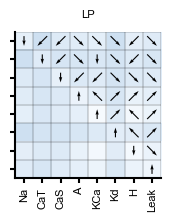

In [82]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.energy_gain_matrix(everything_LP, figsize=(1.9, 1.9), title="LP", lims=[0., 60.], ylabel=False)
    plt.savefig(PANEL_D2, facecolor='None', transparent=True)
    plt.show()

### PY

In [83]:
# energies = x["energies"]
# energies_tt = torch.as_tensor(energies.to_numpy())
# x_tt = torch.as_tensor(x.to_numpy(), dtype=torch.float32)

# num_test = 1000
# theta_test = torch.as_tensor(theta.to_numpy()[:num_test], dtype=torch.float32)
# theta_train = torch.as_tensor(theta.to_numpy()[num_test:], dtype=torch.float32)

# train_energy = torch.as_tensor(
#     energies_tt[num_test:, 2].unsqueeze(1), dtype=torch.float32
# )
# test_energy = torch.as_tensor(
#     energies_tt[:num_test, 2].unsqueeze(1), dtype=torch.float32
# )
# torch.manual_seed(0)
# sensitivity = ActiveSubspace(posterior)
# converged_nn_PY = sensitivity.add_property(
#     theta_train, train_energy, hidden_features=20, num_blocks=1
# ).train()

In [84]:
# with open(
#     "../../../results/conditional_correlation_energy/converged_net_PY.pickle",
#     "wb",
# ) as handle:
#     pickle.dump(converged_nn_PY, handle)

In [85]:
# with open(
#     "../../../results/conditional_correlation_energy/converged_net_PY.pickle",
#     "rb",
# ) as handle:
#     converged_nn_PY = pickle.load(handle)

In [86]:
# everything_PY = []
# for specific_condition in condition_batch:
#     (
#         all_conditional_correlations,
#         all_energy_images,
#         all_energy_specific,
#         all_energy_per_spike,
#         all_num_spikes_per_burst,
#     ) = helpers.generate_and_store_data(
#         neuron1=np.arange(16,24),
#         neuron2=np.arange(16,24),
#         neuron_to_observe='PY',
#         grid_bins=grid_bins,
#         posterior=posterior,
#         condition1_norm=specific_condition.unsqueeze(0),
#         lims_unnorm=lims_unnorm,
#         stats_std=stats_std,
#         regression_net=fitted_reg,
#         theta_mean=mean_params,
#         theta_std=std_params,
#         x_mean=mean_energy.numpy(),
#         x_std=std_energy.numpy(),
#         min_prob=threshold_for_simulating,
#     )
#     print("Done")
#     everything_PY.append(all_energy_specific)

In [87]:
# with open("../../../results/conditional_correlation_energy/211021_everything_py.pickle", "wb") as handle:
#     pickle.dump(everything_PY, handle)

In [88]:
with open("../../../results/conditional_correlation_energy/211021_everything_py.pickle", "rb") as handle:
    everything_PY = pickle.load(handle)

In [89]:
# with open(
#     "../../../results/conditional_correlation_energy/211007_PY_all_stored_data_from_all_energy_specific_nn.pickle",
#     "rb",
# ) as handle:
#     all_energy_images = pickle.load(handle)

max diag 36.72721546148611
max 55.019499282462604


<ipython-input-90-94f668c1df9c>:3: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im)


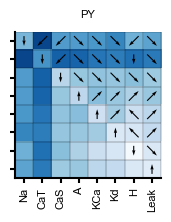

In [90]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    im = viz.energy_gain_matrix(everything_PY, figsize=(1.9, 1.9), title="PY", lims=[0, 60], ylabel=False)
    fig.colorbar(im)
    plt.savefig("demo.png", dpi=200, bbox_inches="tight")
    plt.savefig(PANEL_D3, facecolor='None', transparent=True)
    plt.show()

### Synapses

In [91]:
# pairs_syn = np.asarray(
#     [
#         [24, 8],
#         [24, 9],
#         [24, 10],
#         [24, 11],
#         [24, 12],
#         [24, 13],
#         [24, 14],
#         [24, 15],  # LP
#         [25, 8],
#         [25, 9],
#         [25, 10],
#         [25, 11],
#         [25, 12],
#         [25, 13],
#         [25, 14],
#         [25, 15],  # LP
#         [26, 16],
#         [26, 17],
#         [26, 18],
#         [26, 19],
#         [26, 20],
#         [26, 21],
#         [26, 22],
#         [26, 23],  # PY
#         [27, 16],
#         [27, 17],
#         [27, 18],
#         [27, 19],
#         [27, 20],
#         [27, 21],
#         [27, 22],
#         [27, 23],  # PY
#         [28, 0],
#         [28, 1],
#         [28, 2],
#         [28, 3],
#         [28, 4],
#         [28, 5],
#         [28, 6],
#         [28, 7],  # PD
#         [29, 16],
#         [29, 17],
#         [29, 18],
#         [29, 19],
#         [29, 20],
#         [29, 21],
#         [29, 22],
#         [29, 23],  # PY
#         [30, 8],
#         [30, 9],
#         [30, 10],
#         [30, 11],
#         [30, 12],
#         [30, 13],
#         [30, 14],
#         [30, 15],
#     ]  # LP
# )
# neuron_to_observe = ["LP"] * 16 + ["PY"] * 16 + ["PM"] * 8 + ["PY"] * 8 + ["LP"] * 8

# everything_syn = []
# for specific_condition in condition_batch:
#     (
#         all_conditional_correlations,
#         all_energy_images,
#         all_energy_specific,
#         all_energy_per_spike,
#         all_num_spikes_per_burst,
#     ) = helpers.generate_and_store_data(
#         pairs=pairs_syn,
#         neuron1=np.arange(16,24),
#         neuron2=np.arange(16,24),
#         neuron_to_observe=neuron_to_observe,
#         grid_bins=grid_bins,
#         posterior=posterior,
#         condition1_norm=specific_condition.unsqueeze(0),
#         lims_unnorm=lims_unnorm,
#         stats_std=stats_std,
#         store_as='Synapses',
#         regression_net=fitted_reg,
#         theta_mean=mean_params,
#         theta_std=std_params,
#         x_mean=mean_energy.numpy(),
#         x_std=std_energy.numpy(),
#         min_prob=threshold_for_simulating,
#     )
#     print("Done")
#     everything_syn.append(all_energy_specific)

In [92]:
# with open("../../../results/conditional_correlation_energy/211021_everything_syn.pickle", "wb") as handle:
#     pickle.dump(everything_syn, handle)

In [93]:
with open("../../../results/conditional_correlation_energy/211021_everything_syn.pickle", "rb") as handle:
    everything_syn = pickle.load(handle)

In [94]:
# with open(
#     "../../../results/conditional_correlation_energy/211007_Synapses_all_stored_data_from_all_energy_specific_nn.pickle",
#     "rb",
# ) as handle:
#     all_energy_images = pickle.load(handle)

max 43.660108093769175


<ipython-input-95-c8530e095f84>:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im)


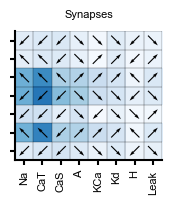

In [95]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    im = viz.energy_gain_matrix_syn(
        everything_syn, figsize=(1.9, 1.9), title="Synapses", lims=[0, 60], ylabel=False
    )
    fig.colorbar(im)
    plt.savefig(PANEL_D4, facecolor='None', transparent=True)
    plt.show()

In [96]:
pairs_syn = np.asarray(
    [
        [24, 24],
        [25, 25],
        [26, 26],
        [27, 27],
        [28, 28],
        [29, 29],
        [30, 30],
    ]  # LP
)
neuron_to_observe = ["LP"] * 16 + ["PY"] * 16 + ["PM"] * 8 + ["PY"] * 8 + ["LP"] * 8

everything_syn_vec = []
for specific_condition in condition_batch:
    (
        all_conditional_correlations,
        all_energy_images,
        all_energy_specific,
        all_energy_per_spike,
        all_num_spikes_per_burst,
    ) = helpers.generate_and_store_data(
        pairs=pairs_syn,
        neuron1=np.arange(16,24),
        neuron2=np.arange(16,24),
        neuron_to_observe=neuron_to_observe,
        grid_bins=grid_bins,
        posterior=posterior,
        condition1_norm=specific_condition.unsqueeze(0),
        lims_unnorm=lims_unnorm,
        stats_std=stats_std,
        store_as='Synapses',
        regression_net=fitted_reg,
        theta_mean=mean_params,
        theta_std=std_params,
        x_mean=mean_energy.numpy(),
        x_std=std_energy.numpy(),
        min_prob=threshold_for_simulating,
    )
    everything_syn_vec.append(all_energy_specific)

max 2.298461813854596


<ipython-input-97-4a2f00b422ba>:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im)


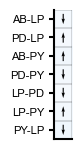

In [97]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    im = viz.energy_gain_matrix_syn_vec(
        everything_syn_vec, figsize=(1.68, 1.68), title="", lims=[0, 60]
    )
    fig.colorbar(im)
    plt.savefig(PANEL_D5, facecolor='None', transparent=True)
    plt.show()

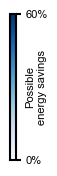

In [98]:
with mpl.rc_context(fname="../../../.matplotlibrc"):

    # draw a new figure and replot the colorbar there
    fig, ax = plt.subplots(figsize=(1.9, 1.9))
    cb = plt.colorbar(im, ax=ax, aspect=25)

    # cb.outline.set_color('white')

    cb.outline.set_edgecolor("k")
    #cb.outline.set_linewidth(0.2)

    cb.set_ticks([0.0, 60])  # vertically oriented colorbar
    cb.ax.set_yticklabels(["0%", "60%"])  # vertically oriented colorbar

    cb.ax.set_ylabel("Possible\nenergy savings")# \n in respective neuron")
    cb.ax.yaxis.labelpad = -16

    ax.remove()
    plt.savefig(PANEL_D6, facecolor='None', transparent=True)
    plt.show()

# Assemble figure

In [44]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [45]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_white = {'size': '7.7pt', 'font': 'Arial', 'color': '#FFFFFF'}

sizefactor = 1.0
dshift = 0.5*factor_svg

f = Figure("20.3cm", "9.4cm",

   Panel(
        SVG(PANEL_B0).scale(svg_scale),
        Text("a", 0.0*factor_svg, 2.3*factor_svg, **kwargs_text),
    ).move(0.0*factor_svg, 0.0*factor_svg),
               
#     Panel(
#         SVG(PANEL_C0).scale(svg_scale),
#         Text("b", -0.8*factor_svg, 2.2*factor_svg, **kwargs_text),
#     ).move(25.3*factor_svg, 0.1*factor_svg),
    
    Panel(
        SVG(PANEL_C1).scale(svg_scale),
        Text("b", -2*factor_svg, 2.6*factor_svg, **kwargs_text),
#         if arrows:
#             Text("d", 9.2*factor_svg, 9.0*factor_svg, **kwargs_text8pt_white),
#             Text("e", 18.6*factor_svg, 18.5*factor_svg, **kwargs_text8pt_white),
        Text("c", 10.2*factor_svg, 4.3*factor_svg, **kwargs_text8pt_white),
        Text("d", 22.7*factor_svg, 17.7*factor_svg, **kwargs_text8pt_white),
    ).move(29.3*factor_svg, -0.3*factor_svg),
    
    Panel(
        SVG(PANEL_C_CBAR).scale(svg_scale),
    ).move(54.5*factor_svg, 0.5*factor_svg),
    
    Panel(
        SVG(PANEL_C3).scale(svg_scale),
        Text("c", -1*factor_svg, 1.1*factor_svg, **kwargs_text),
    ).move(70*factor_svg, 1.4*factor_svg),
           
    Panel(
        SVG(PANEL_C2).scale(svg_scale),
        Text("d", -1*factor_svg, 0.65*factor_svg, **kwargs_text),
    ).move(110*factor_svg, 1.65*factor_svg),
    
    Panel(
        SVG(PANEL_D1).scale(svg_scale),
        Text("e", 0*factor_svg, 2*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 29*factor_svg),
    
    Panel(
        SVG(PANEL_D2).scale(svg_scale),
    ).move(32*factor_svg, 29*factor_svg),
    
    Panel(
        SVG(PANEL_D3).scale(svg_scale),
    ).move(59*factor_svg, 29*factor_svg),
           
    Panel(
        SVG(PANEL_D5).scale(svg_scale),
        Text("f", 1.0*factor_svg, -4.35*factor_svg, **kwargs_text),
    ).move(88.7*factor_svg, 35.35*factor_svg),
    
    Panel(
        SVG(PANEL_D4).scale(svg_scale),
    ).move(101*factor_svg, 31.75*factor_svg),
           
    Panel(
        SVG(PANEL_D6).scale(svg_scale),
    ).move(129.7*factor_svg, 31.65*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig5_cc.svg")
svg('../fig/fig5_cc.svg')

### Matrix with energy consumption in each neuron

In [112]:
theta_np = theta.to_numpy()
num_test = 500
energies = x['energies'].to_numpy()[:, 0] / 10 / 1000

test_params = theta_np[:num_test]
train_params = theta_np[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

train_energy_ABPD = torch.as_tensor(energies)[num_test:].unsqueeze(1)
test_energy_ABPD = torch.as_tensor(energies)[:num_test].unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

regressor = LinearRegression()
fitted_reg_ABPD = regressor.fit(train_params_norm, train_energy_ABPD_norm)
# predictions = fitted_reg_ABPD.predict(test_params_norm)
# coeff = np.asarray([fitted_reg.coef_[0]])
# coeff = coeff / np.linalg.norm(coeff)

In [117]:
# everything_ABPD = []
# for specific_condition in condition_batch:
#     (
#         all_conditional_correlations,
#         all_energy_images,
#         all_energy_specific,
#         all_energy_per_spike,
#         all_num_spikes_per_burst,
#     ) = helpers.generate_and_store_data(
#         neuron1=np.arange(8),
#         neuron2=np.arange(8),
#         neuron_to_observe='PM',
#         grid_bins=grid_bins,
#         posterior=posterior,
#         condition1_norm=specific_condition.unsqueeze(0),
#         lims_unnorm=lims_unnorm,
#         stats_std=stats_std,
#         regression_net=fitted_reg_ABPD,
#         theta_mean=mean_params,
#         theta_std=std_params,
#         x_mean=mean_energy.numpy(),
#         x_std=std_energy.numpy(),
#         min_prob=threshold_for_simulating,
#     )
#     print("Done")
#     everything_ABPD.append(all_energy_specific)

In [118]:
# with open("../../../results/conditional_correlation_energy/211022_everything_ABPD_specific_neuron.pickle", "wb") as handle:
#     pickle.dump(everything_ABPD, handle)

In [119]:
with open("../../../results/conditional_correlation_energy/211022_everything_ABPD_specific_neuron.pickle", "rb") as handle:
    everything_ABPD = pickle.load(handle)

max diag 42.944905603586385
max 78.81951305771574


<ipython-input-120-b040958e3acf>:3: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im)


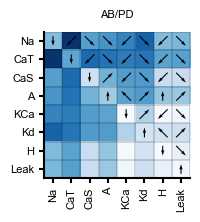

In [120]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    im = viz.energy_gain_matrix(everything_ABPD, figsize=(1.9, 1.9), title="AB/PD", lims=[0, 80], ylabel=True)
    fig.colorbar(im)
    plt.savefig("demo.png", dpi=200, bbox_inches="tight")
    plt.savefig(PANEL_D1_supp, facecolor='None', transparent=True)
    plt.show()

In [121]:
theta_np = theta.to_numpy()
num_test = 500
energies = x['energies'].to_numpy()[:, 1] / 10 / 1000

test_params = theta_np[:num_test]
train_params = theta_np[num_test:]

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

train_energy_ABPD = torch.as_tensor(energies)[num_test:].unsqueeze(1)
test_energy_ABPD = torch.as_tensor(energies)[:num_test].unsqueeze(1)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

regressor = LinearRegression()
fitted_reg_LP = regressor.fit(train_params_norm, train_energy_ABPD_norm)

In [122]:
# everything_LP = []
# for specific_condition in condition_batch:
#     (
#         all_conditional_correlations,
#         all_energy_images,
#         all_energy_specific,
#         all_energy_per_spike,
#         all_num_spikes_per_burst,
#     ) = helpers.generate_and_store_data(
#         neuron1=np.arange(8,16),
#         neuron2=np.arange(8,16),
#         neuron_to_observe='LP',
#         grid_bins=grid_bins,
#         posterior=posterior,
#         condition1_norm=specific_condition.unsqueeze(0),
#         lims_unnorm=lims_unnorm,
#         stats_std=stats_std,
#         regression_net=fitted_reg_LP,
#         theta_mean=mean_params,
#         theta_std=std_params,
#         x_mean=mean_energy.numpy(),
#         x_std=std_energy.numpy(),
#         min_prob=threshold_for_simulating,
#     )
#     print("Done")
#     everything_LP.append(all_energy_specific)

In [123]:
# with open("../../../results/conditional_correlation_energy/211022_everything_LP_specific_neuron.pickle", "wb") as handle:
#     pickle.dump(everything_LP, handle)

In [124]:
with open("../../../results/conditional_correlation_energy/211022_everything_LP_specific_neuron.pickle", "rb") as handle:
    everything_LP = pickle.load(handle)

max diag 49.70896766584796
max 69.74140535449824


<ipython-input-125-8085b720df3c>:3: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im)


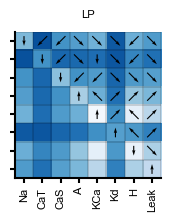

In [125]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    im = viz.energy_gain_matrix(everything_LP, figsize=(1.9, 1.9), title="LP", lims=[0, 80], ylabel=False)
    fig.colorbar(im)
    plt.savefig("demo.png", dpi=200, bbox_inches="tight")
    plt.savefig(PANEL_D2_supp, facecolor='None', transparent=True)
    plt.show()

In [126]:
theta_np = theta.to_numpy()
num_test = 500
energies = x['energies'].to_numpy()[:, 2] / 10 / 1000

test_params = theta_np[:num_test]
train_params = theta_np[num_test:]
# mean_params = np.mean(train_params, axis=0)
# std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

train_energy_ABPD = torch.as_tensor(energies)[num_test:].unsqueeze(1)
test_energy_ABPD = torch.as_tensor(energies)[:num_test].unsqueeze(1)
# mean_energy = torch.mean(train_energy_ABPD)
# std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

regressor = LinearRegression()
fitted_reg_PY = regressor.fit(train_params_norm, train_energy_ABPD_norm)

In [127]:
# everything_PY = []
# for specific_condition in condition_batch:
#     (
#         all_conditional_correlations,
#         all_energy_images,
#         all_energy_specific,
#         all_energy_per_spike,
#         all_num_spikes_per_burst,
#     ) = helpers.generate_and_store_data(
#         neuron1=np.arange(16,24),
#         neuron2=np.arange(16,24),
#         neuron_to_observe='PY',
#         grid_bins=grid_bins,
#         posterior=posterior,
#         condition1_norm=specific_condition.unsqueeze(0),
#         lims_unnorm=lims_unnorm,
#         stats_std=stats_std,
#         regression_net=fitted_reg_PY,
#         theta_mean=mean_params,
#         theta_std=std_params,
#         x_mean=mean_energy.numpy(),
#         x_std=std_energy.numpy(),
#         min_prob=threshold_for_simulating,
#     )
#     print("Done")
#     everything_PY.append(all_energy_specific)

In [128]:
# with open("../../../results/conditional_correlation_energy/211022_everything_PY_specific_neuron.pickle", "wb") as handle:
#     pickle.dump(everything_PY, handle)

In [129]:
with open("../../../results/conditional_correlation_energy/211022_everything_PY_specific_neuron.pickle", "rb") as handle:
    everything_PY = pickle.load(handle)

max diag 54.53503747740458
max 74.67367650427332


<ipython-input-130-23a2c1e80471>:3: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im)


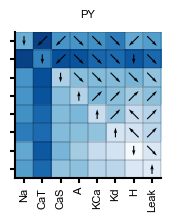

In [130]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    im = viz.energy_gain_matrix(everything_PY, figsize=(1.9, 1.9), title="PY", lims=[0, 80], ylabel=False)
    fig.colorbar(im)
    plt.savefig("demo.png", dpi=200, bbox_inches="tight")
    plt.savefig(PANEL_D3_supp, facecolor='None', transparent=True)
    plt.show()

In [131]:
# pairs_syn = np.asarray(
#     [
#         [24, 8],
#         [24, 9],
#         [24, 10],
#         [24, 11],
#         [24, 12],
#         [24, 13],
#         [24, 14],
#         [24, 15],  # LP
#         [25, 8],
#         [25, 9],
#         [25, 10],
#         [25, 11],
#         [25, 12],
#         [25, 13],
#         [25, 14],
#         [25, 15],  # LP
#         [26, 16],
#         [26, 17],
#         [26, 18],
#         [26, 19],
#         [26, 20],
#         [26, 21],
#         [26, 22],
#         [26, 23],  # PY
#         [27, 16],
#         [27, 17],
#         [27, 18],
#         [27, 19],
#         [27, 20],
#         [27, 21],
#         [27, 22],
#         [27, 23],  # PY
#         [28, 0],
#         [28, 1],
#         [28, 2],
#         [28, 3],
#         [28, 4],
#         [28, 5],
#         [28, 6],
#         [28, 7],  # PD
#         [29, 16],
#         [29, 17],
#         [29, 18],
#         [29, 19],
#         [29, 20],
#         [29, 21],
#         [29, 22],
#         [29, 23],  # PY
#         [30, 8],
#         [30, 9],
#         [30, 10],
#         [30, 11],
#         [30, 12],
#         [30, 13],
#         [30, 14],
#         [30, 15],
#     ]  # LP
# )
# neuron_to_observe = ["LP"] * 16 + ["PY"] * 16 + ["PM"] * 8 + ["PY"] * 8 + ["LP"] * 8

# everything_syn = []
# for specific_condition in condition_batch:
#     (
#         all_conditional_correlations,
#         all_energy_images,
#         all_energy_specific,
#         all_energy_per_spike,
#         all_num_spikes_per_burst,
#     ) = helpers.generate_and_store_data(
#         pairs=pairs_syn,
#         neuron1=np.arange(16,24),
#         neuron2=np.arange(16,24),
#         neuron_to_observe=neuron_to_observe,
#         grid_bins=grid_bins,
#         posterior=posterior,
#         condition1_norm=specific_condition.unsqueeze(0),
#         lims_unnorm=lims_unnorm,
#         stats_std=stats_std,
#         store_as='Synapses',
#         regression_net=None,
#         net1=fitted_reg_ABPD,
#         net2=fitted_reg_LP,
#         net3=fitted_reg_PY,
#         theta_mean=mean_params,
#         theta_std=std_params,
#         x_mean=mean_energy.numpy(),
#         x_std=std_energy.numpy(),
#         min_prob=threshold_for_simulating,
#     )
#     print("Done")
#     everything_syn.append(all_energy_specific)

In [128]:
# with open("../../../results/conditional_correlation_energy/211022_everything_syn_specific_neuron.pickle", "wb") as handle:
#     pickle.dump(everything_syn, handle)

In [132]:
with open("../../../results/conditional_correlation_energy/211022_everything_syn_specific_neuron.pickle", "rb") as handle:
    everything_syn = pickle.load(handle)

max 65.12384852393726


<ipython-input-133-3a543055ff2a>:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im)


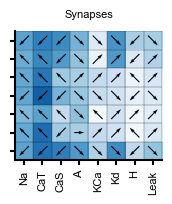

In [133]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    im = viz.energy_gain_matrix_syn(
        everything_syn, figsize=(1.9, 1.9), title="Synapses", lims=[0, 80], ylabel=False
    )
    fig.colorbar(im)
    plt.savefig(PANEL_D4_supp, facecolor='None', transparent=True)
    plt.show()

In [134]:
# pairs_syn = np.asarray(
#     [
#         [24, 24],
#         [25, 25],
#         [26, 26],
#         [27, 27],
#         [28, 28],
#         [29, 29],
#         [30, 30],
#     ]  # LP
# )
# neuron_to_observe = ["LP"] * 16 + ["PY"] * 16 + ["PM"] * 8 + ["PY"] * 8 + ["LP"] * 8

# everything_syn_vec = []
# for specific_condition in condition_batch:
#     (
#         all_conditional_correlations,
#         all_energy_images,
#         all_energy_specific,
#         all_energy_per_spike,
#         all_num_spikes_per_burst,
#     ) = helpers.generate_and_store_data(
#         pairs=pairs_syn,
#         neuron1=np.arange(16,24),
#         neuron2=np.arange(16,24),
#         neuron_to_observe=neuron_to_observe,
#         grid_bins=grid_bins,
#         posterior=posterior,
#         condition1_norm=specific_condition.unsqueeze(0),
#         lims_unnorm=lims_unnorm,
#         stats_std=stats_std,
#         store_as='Synapses',
#         regression_net=None,
#         net1=fitted_reg_ABPD,
#         net2=fitted_reg_LP,
#         net3=fitted_reg_PY,
#         theta_mean=mean_params,
#         theta_std=std_params,
#         x_mean=mean_energy.numpy(),
#         x_std=std_energy.numpy(),
#         min_prob=threshold_for_simulating,
#     )
#     everything_syn_vec.append(all_energy_specific)

max 2.298461813854596


<ipython-input-135-632284004048>:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im)


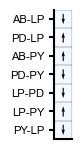

In [135]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    im = viz.energy_gain_matrix_syn_vec(
        everything_syn_vec, figsize=(1.68, 1.68), title="", lims=[0, 80]
    )
    fig.colorbar(im)
    plt.savefig(PANEL_D5_supp, facecolor='None', transparent=True)
    plt.show()

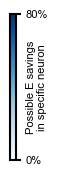

In [136]:
with mpl.rc_context(fname="../../../.matplotlibrc"):

    # draw a new figure and replot the colorbar there
    fig, ax = plt.subplots(figsize=(1.9, 1.9))
    cb = plt.colorbar(im, ax=ax, aspect=25)

    # cb.outline.set_color('white')

    cb.outline.set_edgecolor("k")
    #cb.outline.set_linewidth(0.2)

    cb.set_ticks([0.0, 80])  # vertically oriented colorbar
    cb.ax.set_yticklabels(["0%", "80%"])  # vertically oriented colorbar

    cb.ax.set_ylabel("Possible E savings\nin specific neuron")# \n in respective neuron")
    cb.ax.yaxis.labelpad = -16

    ax.remove()
    plt.savefig(PANEL_D6_supp, facecolor='None', transparent=True)
    plt.show()

In [137]:
from svgutils.compose import *

f = Figure("20.3cm", "5.3cm",

    Panel(
        SVG(PANEL_D1_supp).scale(svg_scale),
        Text("a", 0*factor_svg, 2.3*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 0*factor_svg),
    
    Panel(
        SVG(PANEL_D2_supp).scale(svg_scale),
    ).move(32*factor_svg, 0*factor_svg),
    
    Panel(
        SVG(PANEL_D3_supp).scale(svg_scale),
    ).move(59*factor_svg, 0*factor_svg),
           
    Panel(
        SVG(PANEL_D5_supp).scale(svg_scale),
        Text("b", 1.0*factor_svg, -4.05*factor_svg, **kwargs_text),
    ).move(88.7*factor_svg, 6.35*factor_svg),
    
    Panel(
        SVG(PANEL_D4_supp).scale(svg_scale),
    ).move(101*factor_svg, 2.75*factor_svg),
           
    Panel(
        SVG(PANEL_D6_supp).scale(svg_scale),
    ).move(129.7*factor_svg, 2.65*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig5_cc_supp1.svg")
svg('../fig/fig5_cc_supp1.svg')

### Assemble supplementary

In [588]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_white = {'size': '7.7pt', 'font': 'Arial', 'color': '#FFFFFF'}

sizefactor = 1.0
dshift = 0.5*factor_svg

f = Figure("20.3cm", "4.3cm",

   Panel(
        SVG(PANEL_suppA_traces).scale(svg_scale),
        Text("a", 0*factor_svg, 1.3*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 1.5*factor_svg),
               
    Panel(
        SVG(PANEL_suppB_traces).scale(svg_scale),
        Text("b", -0.8*factor_svg, 1.3*factor_svg, **kwargs_text),
    ).move(48.*factor_svg, 1.0*factor_svg),
           
    Panel(
        SVG(PANEL_suppC_traces).scale(svg_scale),
        Text("c", -0.8*factor_svg, 1.3*factor_svg, **kwargs_text),
    ).move(96.*factor_svg, 1.0*factor_svg),

)

!mkdir -p fig
f.save("../fig/fig5_supp_traces.svg")
svg('../fig/fig5_supp_traces.svg')

# Old stuff

In [210]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_white = {'size': '7.7pt', 'font': 'Arial', 'color': '#FFFFFF'}

sizefactor = 1.0
dshift = 0.5*factor_svg

f = Figure("20.3cm", "3.3cm",

   Panel(
        SVG(PANEL_REG_supp_fraction_ABPD).scale(svg_scale),
    ).move(0*factor_svg, 0.0*factor_svg),
           
    Panel(
        SVG(PANEL_REG_supp_fraction_LP).scale(svg_scale),
    ).move(38*factor_svg, 1.7*factor_svg),
           
    Panel(
        SVG(PANEL_REG_supp_fraction_PY).scale(svg_scale),
    ).move(68*factor_svg, 1.7*factor_svg),
           
    Panel(
        SVG(PANEL_REG_supp_fraction_syn).scale(svg_scale),
    ).move(97*factor_svg, 1.7*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig5_supp_fractions.svg")
svg('../fig/fig5_supp_fractions.svg')